# Workbook 6: Data pre-processing

In this workbook, we'll practise data pre-processing methods.

There are 4 main topics in data pre-processing.

1. How to handle noisy data, or features of unequal variance?

Some algorithms (i.e. SVM and neural networks) are only well-defined when the values of each feature concentrate to 0 and have equal variance (it is better to make the variance be about 1). We use normalization to eliminate the differences of mean and variance among features.

Also, sometimes the features are noisy, which may cause overfitting. (e.g. When fitting decision tree regressor, the tree may overly split some continuous features and is not necessary.)
Binning method enables us to resolve this issue.

2. How to fill missing values?

Sometimes we cannot measure some of the features for a portion of observations, which causes missing values (the absence of values). While machine learning algorithms usually involve linear algebra processes, which do not allow missing values in the matrix. In this section, we learn to fill missing values with a reasonable estimation (guess).

3. How to handle redundent dimensions?

Some features are correlated (redundent) or useless. We learn how to remove the redundency by PCA method, when the meaning of the features isn't known. (When we know the meaning of the features, removing redundency based on their real-world meaning is a more reliable way.)

4. How to address the imbalance of classes?

We have learned how to evaluate the performance of a classifier on imbalanced dataset. In this section, we learn to solve the imbalance, or specifically, improve the performance by transferring it to a balanced problem.

*If you're using Google Colaboratory, it doesn't install `scikit-optimize` package by default and this chunk is the terminal command (started with `!`) to install this package.*

*If you're using Jupyter notebook in your own machine, you may not use `!` to escape the terminal command. You should use `pip` command to install packages as normal and do not run this chunk.*

In [1]:
%pip install scikit-optimize

     ---------------------------------------- 0.0/100.3 kB ? eta -:--:--
     -------------------------------------- 100.3/100.3 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the libraries.

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from copy import deepcopy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

## 1. Make the dataset

Before starting, we arbitrarily make a dirty dataset. The columns do not have specific meanings.

In [3]:
m = 20
rs = np.random.RandomState(seed=11764370)
scales_ = np.power(10, rs.uniform(low=-3, high=3, size=m))
x, y = make_classification(n_samples=1000, n_features=m, n_informative=16, n_redundant=2, n_repeated=0, 
                           n_classes=4, n_clusters_per_class=1, weights=[0.5, 0.3, 0.15, 0.01], 
                           flip_y=0.05, hypercube=True, shift=None, scale=scales_, shuffle=True, 
                           random_state=11764370)

Use `pandas.DataFrame.describe` function to generate some descriptive statistics.

It's easy to find the mean and variance of features vary from each variable.

In [4]:
x_descriptive = pd.DataFrame(x).describe(percentiles=(0.05, 0.95)).T
np.round(x_descriptive, 3)

,count,mean,std,min,5%,50%,95%,max
0,1000.0,-37.728,144.628,-531.034,-270.463,-40.720,216.213,370.744
1,1000.0,-2.743,36.797,-111.671,-60.688,-3.588,56.806,147.574
2,1000.0,20.239,23.162,-73.322,-16.574,20.848,57.080,104.327
3,1000.0,-2.251,8.160,-27.741,-15.010,-2.139,11.669,22.498
4,1000.0,-0.004,0.012,-0.039,-0.024,-0.005,0.016,0.044
5,1000.0,-0.049,0.096,-0.344,-0.206,-0.051,0.107,0.315
6,1000.0,-0.489,2.148,-7.469,-4.101,-0.471,2.865,6.868
7,1000.0,-0.751,1.206,-4.546,-2.951,-0.640,1.080,2.813
8,1000.0,238.081,831.623,-2005.223,-1124.098,237.039,1690.967,3169.416
9,1000.0,0.087,0.133,-0.341,-0.137,0.085,0.301,0.476


Split the dataset into training and testing set.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=6543454)

## 2. Normalization

Normalization is a method for eliminating the difference of the mean and variance of different features. For example, the variance of some features are 1000 and some others are 0.01 in this dataset.

We have learnt decision tree and ensemble methods based on the decision tree. In the decision tree, splitting rules are constructed on a dicrete basis, and the unequal variance is not likely to be a problem.

In contrast, the support vector machine (*we haven't learnt, but it's a good example*) makes classification based on the distance between observations in the data space. If a feature has large variance, the model tends to overestimate its importance when calculating the distance.

First, fit a support vector machine classifier (**Model 1**) with Bayes hyper-parameter search.

In [6]:
svc_1 = BayesSearchCV(
    SVC(cache_size=4096, max_iter=5000),
    {
      'C': Real(0.001, 100, prior='log-uniform'),
      'gamma': Real(0.01, 0.5, prior='uniform'),
    },
    cv=5, random_state=10459, n_iter=32, n_jobs=-1
)
svc_1.fit(x_train, y_train)

BayesSearchCV(cv=5, estimator=SVC(cache_size=4096, max_iter=5000), n_iter=32,
              n_jobs=-1, random_state=10459,
              search_spaces={'C': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=0.01, high=0.5, prior='uniform', transform='normalize')})

We evaluate the training and testing F1 score for model 1.

In [7]:
y_train_hat = svc_1.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = svc_1.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))

Training set F1: 0.3347231473771856
Testing set F1: 0.35013201320132015


Actually SVC doesn't figure out any meaningful rules. It only predicts the major class. See the confusion matrix.

In [8]:
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training CM:
 [[401   0   0   0]
 [245   0   0   0]
 [131   0   0   0]
 [ 23   0   0   0]]
Testing CM:
 [[103   0   0   0]
 [ 67   0   0   0]
 [ 26   0   0   0]
 [  4   0   0   0]]


### 2.1. Z-score normalization

One of the pre-processing method to tackle this problem is normalization. Among various kinds of normalization, we first practise the Z-score normalization.

In [9]:
std_ = StandardScaler()
x_train_std = std_.fit_transform(x_train)
x_test_std = std_.transform(x_test)

With the normalized dataset, we fit the same SVC model (**model 2**) again and evaluate it.

In [10]:
svc_2 = BayesSearchCV(
    SVC(cache_size=4096, max_iter=5000),
    {
      'C': Real(0.001, 100, prior='log-uniform'),
      'gamma': Real(0.01, 0.5, prior='uniform'),
    },
    cv=5, random_state=10459, n_iter=32, n_jobs=-1
)
svc_2.fit(x_train_std, y_train)

BayesSearchCV(cv=5, estimator=SVC(cache_size=4096, max_iter=5000), n_iter=32,
              n_jobs=-1, random_state=10459,
              search_spaces={'C': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=0.01, high=0.5, prior='uniform', transform='normalize')})

We evaluate the training and testing F1 score for model 2.

In [11]:
y_train_hat = svc_2.predict(x_train_std)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = svc_2.predict(x_test_std)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.9837094826515118
Testing set F1: 0.9383942225998303
Training CM:
 [[397   3   1   0]
 [  3 241   1   0]
 [  3   0 128   0]
 [  2   0   0  21]]
Testing CM:
 [[101   2   0   0]
 [  4  63   0   0]
 [  4   0  22   0]
 [  2   0   0   2]]


As seen from the result, Z-score normalization leads to a huge improvement.

### 2.2. Min-Max normalization

Besides Z-score normalization, we have also learnt min-max normalization, which performs a linear transformation for each features to 0-1 scale.

In [12]:
minmax = MinMaxScaler()
x_train_zip = minmax.fit_transform(x_train)
x_test_zip = minmax.transform(x_test)

With the normalized dataset, we fit the same SVC model (**model 3**) again and evaluate it.

In [13]:
svc_3 = BayesSearchCV(
    SVC(cache_size=4096, max_iter=5000),
    {
      'C': Real(0.001, 100, prior='log-uniform'),
      'gamma': Real(0.01, 0.5, prior='uniform'),
    },
    cv=5, random_state=10459, n_iter=32, n_jobs=-1
)
svc_3.fit(x_train_zip, y_train)

BayesSearchCV(cv=5, estimator=SVC(cache_size=4096, max_iter=5000), n_iter=32,
              n_jobs=-1, random_state=10459,
              search_spaces={'C': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=0.01, high=0.5, prior='uniform', transform='normalize')})

We evaluate the training and testing F1 score for model 3.

In [14]:
y_train_hat = svc_3.predict(x_train_zip)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = svc_3.predict(x_test_zip)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.9607441667315981
Testing set F1: 0.928475675067059
Training CM:
 [[393   5   3   0]
 [  6 238   1   0]
 [  9   1 121   0]
 [  4   0   2  17]]
Testing CM:
 [[100   2   1   0]
 [  5  62   0   0]
 [  4   0  22   0]
 [  2   0   0   2]]


It reaches quite similar result as Z-score normalization. However, we should notice this method is not robust, because if outliers (extreme values) exist in some features, the normal values will be zipped into a small interval.

E.g. The normal range is (0, 100) and there is a extreme value 10,000. The normal range will be zipped into (0, 0.01) after min-max normalization, while the other 99% length in this dimension is wasted.

As an improvement, we use `RobustScaler` and assign the quantile manually, and this issue can be resolved. [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

## 3. Binning

Decision tree can be a good example to present the benefit of binning. It will not affected by unequal mean and variance, because it consider each feature as a dicrete feature. However, the issue of noisy data has larger effect on the decision tree than other models.

First, we fit a decision tree (**model 4**) with the raw dataset. Get the depth of the unpruned tree.

In [15]:
dt = DecisionTreeClassifier(random_state=29458)
dt.fit(x_train, y_train)
dt.get_depth()

17

Tune hyper-parameters.

In [16]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

We evaluate the training and testing F1 score for model 4.

In [17]:
y_train_hat = dt_auto_depth.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.8987467269764289
Testing set F1: 0.7673339977540707
Training CM:
 [[383  16   2   0]
 [ 20 225   0   0]
 [ 19   7 105   0]
 [  7   4   3   9]]
Testing CM:
 [[86  8  9  0]
 [ 8 56  2  1]
 [ 8  5 13  0]
 [ 3  1  0  0]]


The model predicts some variables belonging to other classes as the major class.

We use binning method to redice the noise in the dataset. By default, it uses `strategy='quantile'` and follows the equal-depth criteria.

In [18]:
class BinningWrapper(TransformerMixin):
  def __init__(self, n_bins=None, n_features=None, **features):
    self.n_bins = n_bins
    self.cols = np.zeros(n_features, dtype=int)
    for i in range(n_features):
      self.cols[i] = features.get(f'feature_{i}', 0)
    self.bin = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', random_state=217334)

  def fit(self, x, y=None):
    x_ = deepcopy(x)
    if isinstance(x_, pd.DataFrame):
      x_ = x_.values
    self.bin.fit(x_[:, self.cols])
    return self
  
  def transform(self, x):
    x_ = deepcopy(x)
    if isinstance(x_, pd.DataFrame):
      x_ = x_.values
    x_[:, self.cols] = self.bin.transform(x_[:, self.cols])
    return x_

  def set_params(self, **kwargs):
    for k, v in kwargs.items():
      self.__dict__[k] = v
    if 'n_bins' in kwargs.keys():
      self.bin = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', random_state=217334)

We fit the same decision tree (**model 5**) on the dataset after binning.

In [19]:
bin_pipeline = BayesSearchCV(
    Pipeline([
        ('bin', BinningWrapper(n_features=x_train.shape[1])),
        ('dt', DecisionTreeClassifier(random_state=29458)),
    ]),
    {'dt__max_depth': (3, 17),
     'bin__n_bins': (5, 15),
     } | {f'bin__feature_{i}': (0, 1) for i in range(x_train.shape[1])},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
bin_pipeline.fit(x_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('bin',
                                         <__main__.BinningWrapper object at 0x7f8193798b80>),
                                        ('dt',
                                         DecisionTreeClassifier(random_state=29458))]),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'bin__feature_0': (0, 1), 'bin__feature_1': (0, 1),
                             'bin__feature_10': (0, 1),
                             'bin__feature_11': (0, 1),
                             'bin__feature_12': (0, 1),
                             'bin__feature_13': (0, 1),
                             '...,
                             'bin__feature_15': (0, 1),
                             'bin__feature_16': (0, 1),
                             'bin__feature_17': (0, 1),
                             'bin__feature_18': (0, 1),
                             'bin__feature_19': (0, 1),
                             'bin__feature_2': (0, 1), 'bin__feature_3': (0, 1),
                             'bin__feature_4': (0, 1), 'bin__feature_5': (0, 1),
                             'bin__feature_6': (0, 1), 'bin__feature_7': (0, 1),
                             'bin__feature_8': (0, 1), 'bin__feature_9': (0, 1),
                             'bin__n_bins': (5, 15), 'dt__max_depth': (3, 17)})

We evaluate the training and testing F1 score for model 5.

In [20]:
y_train_hat = bin_pipeline.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = bin_pipeline.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.8987467269764289
Testing set F1: 0.7673339977540707
Training CM:
 [[383  16   2   0]
 [ 20 225   0   0]
 [ 19   7 105   0]
 [  7   4   3   9]]
Testing CM:
 [[86  8  9  0]
 [ 8 56  2  1]
 [ 8  5 13  0]
 [ 3  1  0  0]]


Which features does the model dicretize?

In [21]:
bin_pipeline.best_params_

OrderedDict([('bin__feature_0', 1),
             ('bin__feature_1', 1),
             ('bin__feature_10', 0),
             ('bin__feature_11', 0),
             ('bin__feature_12', 0),
             ('bin__feature_13', 1),
             ('bin__feature_14', 0),
             ('bin__feature_15', 0),
             ('bin__feature_16', 0),
             ('bin__feature_17', 0),
             ('bin__feature_18', 0),
             ('bin__feature_19', 0),
             ('bin__feature_2', 0),
             ('bin__feature_3', 0),
             ('bin__feature_4', 1),
             ('bin__feature_5', 1),
             ('bin__feature_6', 1),
             ('bin__feature_7', 1),
             ('bin__feature_8', 1),
             ('bin__feature_9', 1),
             ('bin__n_bins', 11),
             ('dt__max_depth', 6)])

## 4. Fill missing values

In this section, we investigate the effect of missing values. To begin with, we design a function to randomly generate some missing values in the training set.

In [22]:
def generate_missing_values(array, missing_ratio, random_state):
  array_ = array.copy()
  rs_ = np.random.RandomState(seed=random_state)
  mask = np.zeros(array_.shape)
  n, m = array_.shape
  adjusted_values = rs_.choice(n * m, size=int(n * m * missing_ratio), replace=False)
  row_idx = adjusted_values // m
  col_idx = adjusted_values % m
  array_[row_idx, col_idx] = np.nan
  return array_

We randomly insert some missing values into the dataset.

In [23]:
x_train_missing = generate_missing_values(x_train, 0.5, random_state=438218623)
x_test_missing = generate_missing_values(x_test, 0.5, random_state=438218623)

### 4.1. Overall mean value

We have learnt several methods to fill the missing value.
First, fill with the overall mean value.

In [24]:
x_train_filled_1 = x_train_missing.copy()
x_test_filled_1 = x_test_missing.copy()
for i in range(x_train_missing.shape[1]):
  mean_ = np.nanmean(x_train_missing[:, i])
  x_train_filled_1[:, i] = np.nan_to_num(x_train_missing[:, i], nan=mean_)
  x_test_filled_1[:, i] = np.nan_to_num(x_test_missing[:, i], nan=mean_)

Fit a decision tree model (**model 6**) to evaluate the improvement.

In [25]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_filled_1, y_train)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

Evaluate the performance of model 6.

In [26]:
y_train_hat = dt_auto_depth.predict(x_train_filled_1)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test_filled_1)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.7101238465940719
Testing set F1: 0.5462115951722252
Training CM:
 [[383  17   1   0]
 [ 92 150   3   0]
 [ 77   4  50   0]
 [ 15   3   2   3]]
Testing CM:
 [[90  8  5  0]
 [41 24  2  0]
 [16  6  4  0]
 [ 4  0  0  0]]


### 4.2. In-class mean value

Second, fill with the mean of the observations with the same class Y.

Notice on testing set, we cannot know Y and have to fallback to method 1.

In [27]:
x_train_filled_2 = x_train_missing.copy()
for uy in np.unique(y_train):
  idx = np.where(y_train == uy)
  for i in range(x_train_missing.shape[1]):
    mean_ = np.nanmean(x_train_missing[idx, i])
    x_train_filled_2[idx, i] = np.nan_to_num(x_train_missing[idx, i], nan=mean_)
x_test_filled_2 = x_test_missing.copy()
for i in range(x_train_missing.shape[1]):
  mean_ = np.nanmean(x_train_missing[:, i])
  x_test_filled_2[:, i] = np.nan_to_num(x_test_missing[:, i], nan=mean_)

Fit a decision tree model (**model 6**) to evaluate the improvement.

In [28]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_filled_2, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

Evaluate the performance of model 6.

In [29]:
y_train_hat = dt_auto_depth.predict(x_train_filled_2)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test_filled_2)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.9773694671545228
Testing set F1: 0.592063157894737
Training CM:
 [[401   0   0   0]
 [  9 236   0   0]
 [  1   3 125   2]
 [  2   1   0  20]]
Testing CM:
 [[90  3  4  6]
 [37 24  2  4]
 [16  1  8  1]
 [ 4  0  0  0]]


### 4.3. New class

Third, fill as a new class. If the variable is continuous, we could use a value that never appeared.

In [30]:
x_train_filled_3 = np.nan_to_num(x_train_missing, nan=np.nanmin(x_train_missing) - 1)
x_test_filled_3 = np.nan_to_num(x_test_missing, nan=np.nanmin(x_train_missing) - 1)

Fit a decision tree model (**model 6**) to evaluate the improvement.

In [31]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_filled_3, y_train)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

Evaluate the performance of model 6.

In [32]:
y_train_hat = dt_auto_depth.predict(x_train_filled_3)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test_filled_3)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.7390614389792667
Testing set F1: 0.5816470465018851
Training CM:
 [[353  33  15   0]
 [ 52 180  13   0]
 [ 52  10  69   0]
 [ 16   5   1   1]]
Testing CM:
 [[79 15  9  0]
 [21 33 13  0]
 [12  8  6  0]
 [ 2  1  1  0]]


## 5. Resample

In this section, we handle the class imbalance. There are 3 methods: oversampling, undersampling, SMOTE.

### 5.1. Oversampling

This method replicates observations of minor classes to make the size equal to the major class.

In [33]:
uy, cy = np.unique(y_train, return_counts=True)
major_class = uy[np.argmax(cy)]
idx_major = y_train == major_class
n_major_class = np.sum(idx_major)
print('The major class is', major_class, 'which has', n_major_class, 'observations.')

The major class is 0 which has 401 observations.


In [34]:
x_train_by_classes = []
rs = np.random.RandomState(seed=8537259)
for uy_ in uy:
  if uy_ == major_class:
    x_train_by_classes.append(x_train[y_train == major_class, :])
    continue
  idx_boot = rs.choice(np.where(y_train == uy_)[0], size=n_major_class)
  x_train_by_classes.append(x_train[idx_boot, :])
x_train_by_classes = np.vstack(x_train_by_classes)
y_train_by_classes = np.repeat(uy, repeats=n_major_class)
p = rs.permutation(y_train_by_classes.shape[0])  # shuffle
x_train_over, y_train_over = x_train_by_classes[p], y_train_by_classes[p]

Fit a decision tree (**model 7**) to evaluate the performance.

In [35]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_over, y_train_over)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

We still evaluate the performance on raw dataset for fair.

In [36]:
y_train_hat = dt_auto_depth.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.9699094431160441
Testing set F1: 0.7364636641253978
Training CM:
 [[395   3   3   0]
 [ 11 229   4   1]
 [  0   1 129   1]
 [  0   0   0  23]]
Testing CM:
 [[85  7  8  3]
 [17 45  4  1]
 [ 9  1 16  0]
 [ 1  1  1  1]]


### 5.2. Undersampling

This method draws observations of major classes to make the size equal to the minor class.

In [37]:
uy, cy = np.unique(y_train, return_counts=True)
minor_class = uy[np.argmin(cy)]
idx_minor = y_train == minor_class
n_minor_class = np.sum(idx_minor)
print('The minor class is', minor_class, 'which has', n_minor_class, 'observations.')

The minor class is 3 which has 23 observations.


In [38]:
x_train_by_classes = []
rs = np.random.RandomState(seed=8537259)
for uy_ in uy:
  if uy_ == major_class:
    x_train_by_classes.append(x_train[y_train == major_class, :])
    continue
  idx_boot = rs.choice(np.where(y_train == uy_)[0], size=n_minor_class, replace=False)
  x_train_by_classes.append(x_train[idx_boot, :])
x_train_by_classes = np.vstack(x_train_by_classes)
y_train_by_classes = np.repeat(uy, repeats=n_minor_class)
p = rs.permutation(y_train_by_classes.shape[0])  # shuffle
x_train_under, y_train_under = x_train_by_classes[p], y_train_by_classes[p]

Fit a decision tree (**model 8**) to evaluate the performance.

In [39]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_under, y_train_under)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

Evaluate the performance.

In [40]:
y_train_hat = dt_auto_depth.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.26122069513492474
Testing set F1: 0.2373137868420887
Training CM:
 [[ 99 124  85  93]
 [ 90  47  64  44]
 [ 15  53  34  29]
 [  4   5   5   9]]
Testing CM:
 [[26 27 24 26]
 [25  8 19 15]
 [ 4 10  6  6]
 [ 1  0  2  1]]


### 5.3. SMOTE

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

The SMOTE class acts like a data transform object from scikit-learn in that it must be defined and configured, fit on a dataset, then applied to create a new transformed version of the dataset.

[Reference](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) Theories

[Reference](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) SMOTE documentation

By default, the number of nearest neighbors used to define the neighborhood of samples is 5.

In [41]:
smote = SMOTE(random_state=2291483, k_neighbors=10)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

Fit a decision tree (**model 9**) to evaluate the performance.

In [42]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_smote, y_train_smote)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

Evaluate the performance.

In [43]:
y_train_hat = dt_auto_depth.predict(x_train)
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test)
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.9962605513473762
Testing set F1: 0.6979244233126322
Training CM:
 [[400   0   1   0]
 [  1 243   0   1]
 [  0   0 131   0]
 [  0   0   0  23]]
Testing CM:
 [[76 12 10  5]
 [ 9 43  8  7]
 [ 5  5 16  0]
 [ 3  0  0  1]]


It improves the performance and enables us to search for the best `k_neighbours`.

## 6. PCA

Some features are redundent or correlated, thus we can re-structure the features to improve the performance.

In [ ]:
pca = PCA(random_state=374564)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

Calculate the ratio of variance explained by each component.

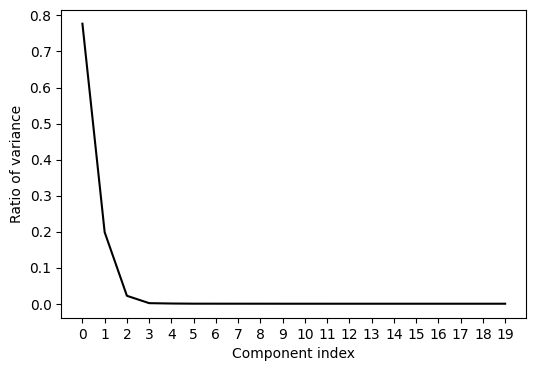

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pca.explained_variance_ratio_, c='k')
ax.set_xticks(np.arange(pca.n_components_))
ax.set_xlabel('Component index')
ax.set_ylabel('Ratio of variance')
plt.show()
plt.close(fig)

Visualize the first 3 dimensions of **the original** training set.

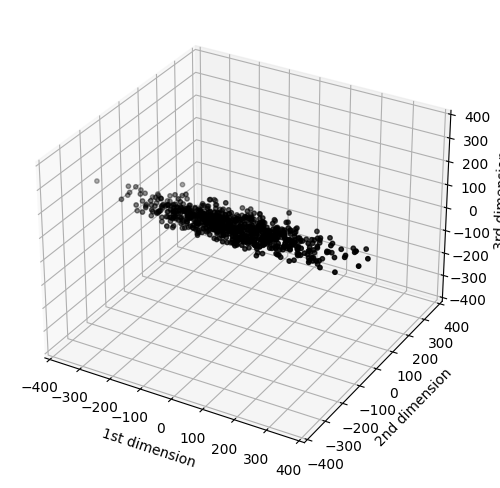

In [46]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "3d"})
ax.scatter(x_train[:, 0], x_train[:, 1], x_train[:, 2], c='k', s=10)
ax.set_xlabel('1st dimension')
ax.set_ylabel('2nd dimension')
ax.set_zlabel('3rd dimension')
ax.set_xlim((-400, 400))
ax.set_ylim((-400, 400))
ax.set_zlim((-400, 400))
plt.show()
plt.close(fig)

Visualize the first 3 dimensions of **PCA transformed** training set.

Notice the difference on axis scales.

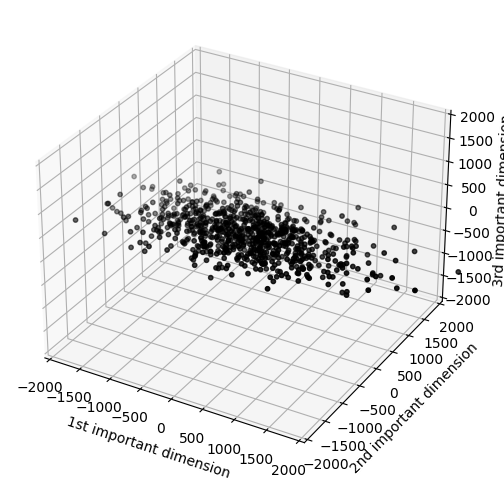

In [47]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "3d"})
ax.scatter(x_train_pca[:, 0], x_train_pca[:, 1], x_train_pca[:, 2], c='k', s=10)
ax.set_xlabel('1st important dimension')
ax.set_ylabel('2nd important dimension')
ax.set_zlabel('3rd important dimension')
ax.set_xlim((-2000, 2000))
ax.set_ylim((-2000, 2000))
ax.set_zlim((-2000, 2000))
plt.show()
plt.close(fig)

Based on the explained variance ratio, we could use the first 2 component and fit a decision tree model (**model 10**).

In [48]:
dt_auto_depth = BayesSearchCV(
    DecisionTreeClassifier(random_state=29458),
    {'max_depth': (3, 17)},
    cv=5, random_state=10459, n_iter=16, n_jobs=-1
)
dt_auto_depth.fit(x_train_pca[:, :2], y_train)

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=29458),
              n_iter=16, n_jobs=-1, random_state=10459,
              search_spaces={'max_depth': (3, 17)})

In [49]:
y_train_hat = dt_auto_depth.predict(x_train_pca[:, :2])
print('Training set F1:', f1_score(y_train, y_train_hat, average='weighted', labels=[0, 1, 2, 3]))
y_test_hat = dt_auto_depth.predict(x_test_pca[:, :2])
print('Testing set F1:', f1_score(y_test, y_test_hat, average='weighted', labels=[0, 1, 2, 3]))
print('Training CM:\n', confusion_matrix(y_train, y_train_hat))
print('Testing CM:\n', confusion_matrix(y_test, y_test_hat))

Training set F1: 0.4943959083275144
Testing set F1: 0.5124842154049543
Training CM:
 [[388  13   0   0]
 [173  70   2   0]
 [105  20   6   0]
 [ 21   1   1   0]]
Testing CM:
 [[97  4  2  0]
 [46 19  2  0]
 [21  4  1  0]
 [ 4  0  0  0]]


Notice we reduce 90% dataset but still achieves 0.51 F1 score.

## 7. Relief

Follow the slide 14 of data pre-processing 3. This algorithm is used to calculate the weights of features and help feature selection.

[KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)

[Distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics)

In [50]:
def relief(x, y, r):
  """
  r: The ratio of random selected observations
  """
  knn_hit = dict()  # calc distance matrix for each class
  knn_miss = dict()
  knn_template = NearestNeighbors(
      metric='minkowski', p=1,  # Manhattan distance
      n_jobs=-1,
      n_neighbors=2,  # the first returned value is itself
  )
  for uy in np.unique(y):
    x_hit, x_miss = x[y == uy], x[y != uy]
    knn_hit[uy] = deepcopy(knn_template)
    knn_hit[uy].fit(x_hit)
    knn_miss[uy] = deepcopy(knn_template)
    knn_miss[uy].fit(x_miss)

  rs = np.random.RandomState(seed=54382)  # get randomly selected instances R
  n_r = int(y.shape[0] * r)
  if n_r > y.shape[0]:  # compatible to bootstrap
    r = rs.choice(y.shape[0], size=n_r, replace=True)
  else:
    r = rs.choice(y.shape[0], size=n_r, replace=False)

  # use np.nan to address mistakes of assigning values
  # expect all values are filled after finishing
  h = np.full(shape=n_r, fill_value=np.nan, dtype=int)
  m = np.full(shape=n_r, fill_value=np.nan, dtype=int)
  for ul in np.unique(y[r]):
    i = y[r] == ul  # the relative index in the drawn instances R
    h[i] = knn_hit[ul].kneighbors(x[r[i]], return_distance=False)[:, 1]
    m[i] = knn_miss[ul].kneighbors(x[r[i]], return_distance=False)[:, 1]

  w = np.square(x[r] - x[m]) - np.square(x[h] - x[m])  # calc weights
  w = np.sum(w, axis=0) / n_r
  return w

Use the dataset as an example to calculate feature weights. Notice the range of y-axis are different.

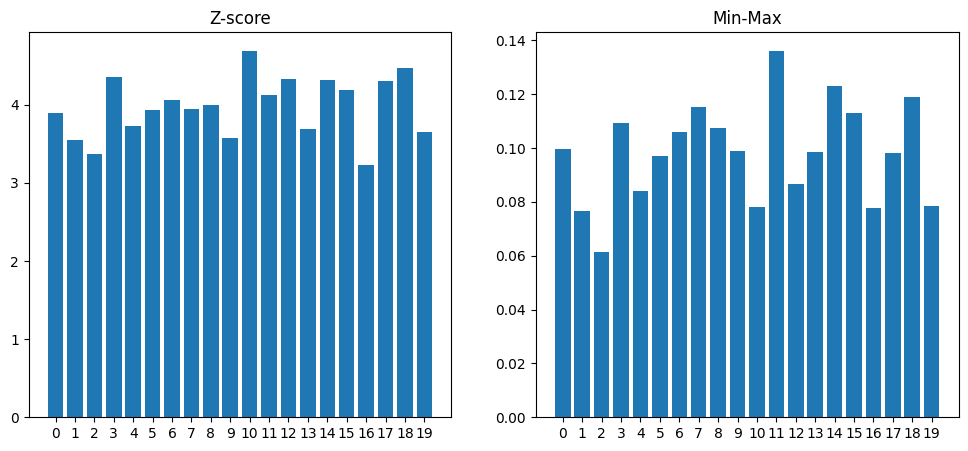

In [51]:
feature_names = np.arange(x_train.shape[1])
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
axes[0].bar(x=feature_names, height=relief(x_train_std, y_train, 0.1))
axes[0].set_xticks(feature_names)
axes[0].set_title("Z-score")
axes[1].bar(x=feature_names, height=relief(x_train_zip, y_train, 0.1))
axes[1].set_xticks(feature_names)
axes[1].set_title("Min-Max")
plt.show()
plt.close(fig)

Refering results.

|                              | Training | Testing | Memo                                                         |
| ---------------------------- | -------- | ------- | ------------------------------------------------------------ |
| **Normalization**            |          |         |                                                              |
| Baseline SVC                 | 0.33     | 0.35    |                                                              |
| Normalization:  Z-score      | 0.98     | 0.94    |                                                              |
| Normalization:  Min-Max      | 0.96     | 0.93    |                                                              |
| **Binning**                  |          |         |                                                              |
| Baseline DT                  | 0.90     | 0.77    |                                                              |
| Binning                      | 0.90     | 0.77    |                                                              |
| **Fill missing  values\***   |          |         | Baseline  not available, because `scikit-learn` decision tree doesn't support missing  values. |
| Fill missing:  overall mean  | 0.71     | 0.55    |                                                              |
| Fill missing:  in-class mean | 0.98     | 0.59\*   | Testing  set cannot apply the same pre-processing, and fallback to overall mean. |
| Fill missing:  new class     | 0.74     | 0.58    |                                                              |
| **Resample**                 |          |         |                                                              |
| Baseline DT                  | 0.90     | 0.77    |                                                              |
| Resample:  oversampling      | 0.97     | 0.74    |                                                              |
| Resample:  undersampling     | 0.26     | 0.24    |                                                              |
| Resample:  SMOTE             | 1.00     | 0.70    |                                                              |
| **PCA**                      |          |         |                                                              |
| Baseline DT                  | 0.90     | 0.77    |                                                              |
| 10%  Information DT          | 0.49     | 0.51    |                                                              |

*If you find any mistakes in these algorithms, please email the tutor.*